In [479]:
import re
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
from pytesseract import Output
from prettytable import PrettyTable

In [416]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

#Display grey scale image
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

#Display RGB colour image
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def bw_scanner(image):
    # Check if the image is in grayscale (if it's not, convert it)
    if len(image.shape) == 3:  # If it's a color image (3 channels)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image  # It's already grayscale
    
    # Convert the image to a PIL image for thresholding
    pil_img = Image.fromarray(gray)

    # Apply manual thresholding (e.g., threshold value = 190)
    threshold_img = pil_img.point(lambda p: p > 190 and 255)

    # Convert the thresholded image back to a NumPy array for OpenCV processing
    threshold_img_np = np.array(threshold_img)

    return threshold_img_np

def convert_to_paragraph(text):
    # Split the text into lines, strip each line, and join with commas
    return ', '.join(line.strip() for line in text.split('\n') if line.strip())

def extract_registration_number(text):
    patterns = [
        r'Registration\s*Number\s*:?\s*([A-Z]{2}\d{2}[A-Z]\d{8})',
        r'([A-Z]{2}\d{2}[A-Z]\d{8})',
        r'Registration\s*Number\s*:?\s*(\S+)'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1)
    return "Not found"

def extract_name(text):
    patterns = [
        r'Name of Candidate\s*[:|]\s*([\w\s.]+?)(?:\n|$)',
        r"Candidate['']s Name\s*[:|]\s*([\w\s.]+?)(?:\n|$)",
        r'Name\s*[:|]\s*([\w\s.]+?)(?:\n|$)'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return "Not found"

def extract_parent_name(text):
    patterns = [
        r"Parent's/Guardian's\s*(?:Name\s*)?\s*([A-Z\s]+(?:\s+[A-Z\s]+){1,3})",
        r"Parent's/Guardian's\s*\n\s*([A-Z\s]+(?:\s+[A-Z\s]+){1,3})",
        r"Parent's/Guardian's\s*([A-Z][A-Z\s]+(?:\s+[A-Z][A-Z\s]+){1,2})",
        r"Parent's/Guardian's\s*([A-Z][a-z]+\s+(?:[A-Z][a-z]+\s+){1,2}[A-Z][a-z]+)"
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE | re.MULTILINE)
        if match:
            return match.group(1).strip()
    
    return "Not found"

def extract_gate_score(text):
    pattern = r'GATE Score\s*:?\s*(\d+)'
    match = re.search(pattern, text, re.IGNORECASE)
    return match.group(1) if match else "Not found"

def extract_date_of_birth(text):
    pattern = r'Date of Birth\s*:?\s*(\d{1,2})[-\s](\w{3})[-\s](\d{4})'
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        day, month, year = match.groups()
        return f"{day} {month} {year}"
    return "Not found"

def extract_examination_paper(text):
    pattern = r'Examination Paper\s*(.*?)(?=\n)'
    match = re.search(pattern, text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else "Not found"

def extract_all_india_rank(text):
    pattern = r'All\s*India\s*Rank\s*in\s*this\s*paper\s*[:|]?\s*(\d{2,4})'
    match = re.search(pattern, text, re.IGNORECASE)
    return match.group(1) if match else "Not found"


def extract_exam_year(text):
    patterns = [
        r'GATE\s+(\d{4})',
        r'Examination Year:\s*(\d{4})',
        r'Year of Examination:\s*(\d{4})'
    ]
    
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1)
    return "Not found"


def extract_gate_info(text):
    return {
        'Name': extract_name(text),
        "Parent's/Guardian's Name": extract_parent_name(text),
        'Registration Number': extract_registration_number(text),
        'Date of Birth': extract_date_of_birth(text),
        'GATE Score': extract_gate_score(text),
        'Examination Paper': extract_examination_paper(text),
        'All India Rank': extract_all_india_rank(text),
        'Exam Year': extract_exam_year(text)
    }



def display_results(results):
    table = PrettyTable()
    table.field_names = ["Field", "Value"]
    table.align["Field"] = "l"
    table.align["Value"] = "l"
    
    for key, value in results.items():
        table.add_row([key, value])
    
    print(table)


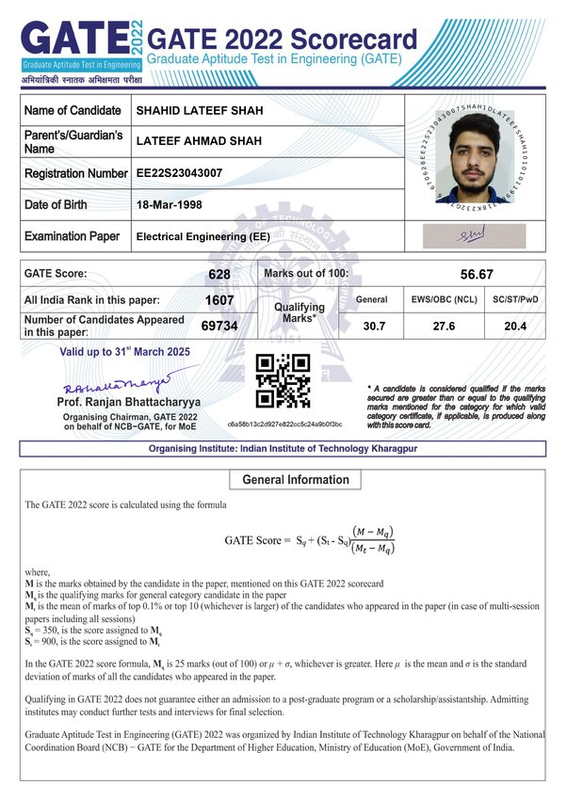

In [575]:
img_name = '/Users/manavpathak/Gate_Validation/images/Scorecard3.jpeg'
img = Image.open(img_name)
img.thumbnail((800, 800), Image.LANCZOS)
img

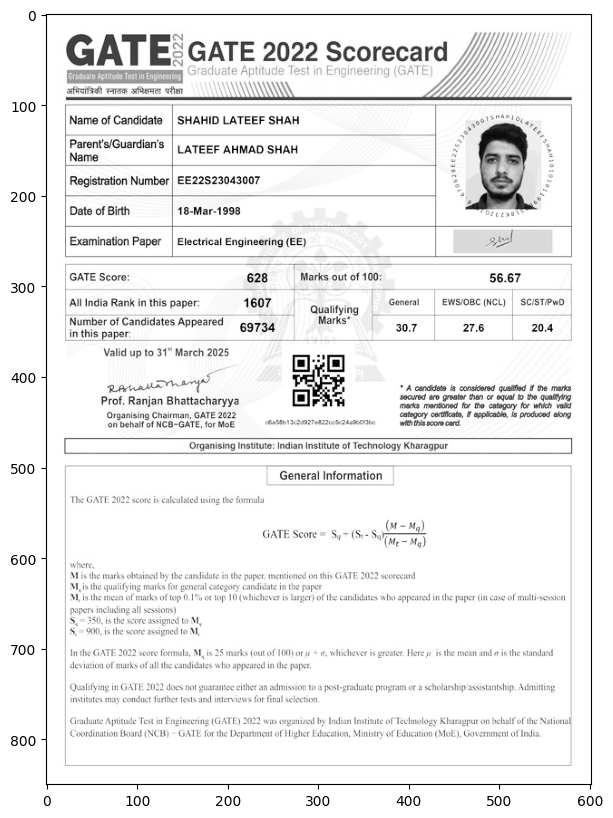

In [576]:
image = cv2.imread(img_name)
grayi = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(grayi)

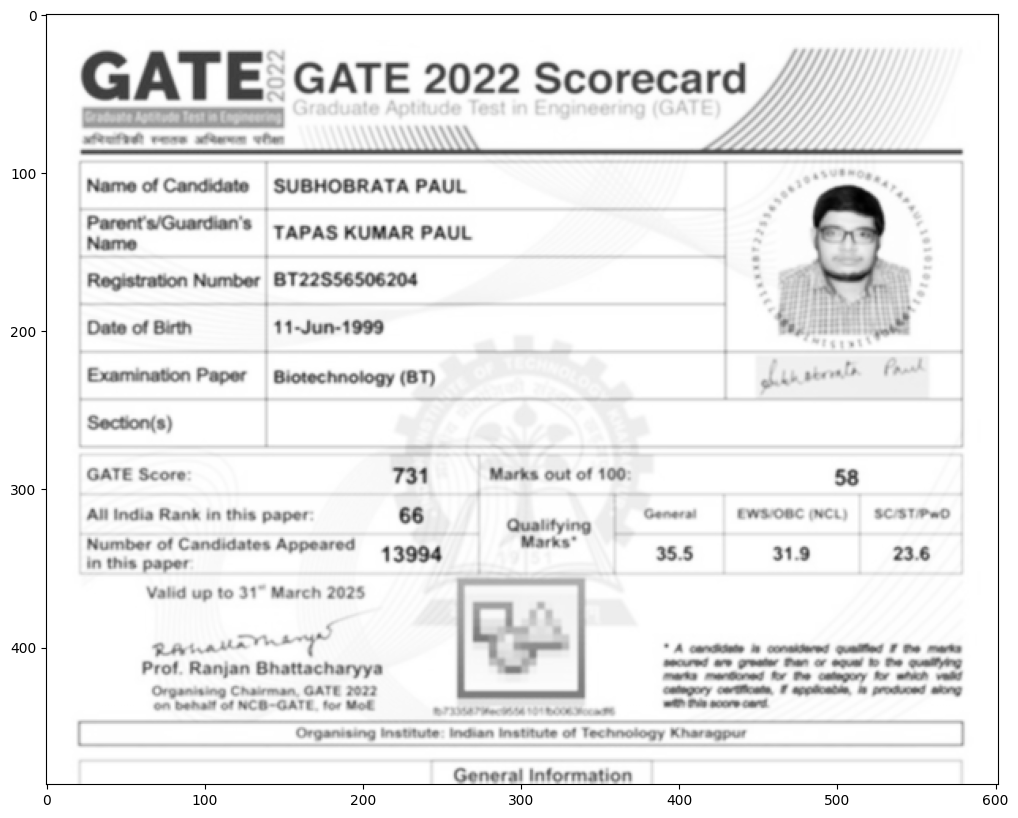

In [512]:
blurred = cv2.GaussianBlur(grayi, (3, 3), 1)
plot_gray(blurred)

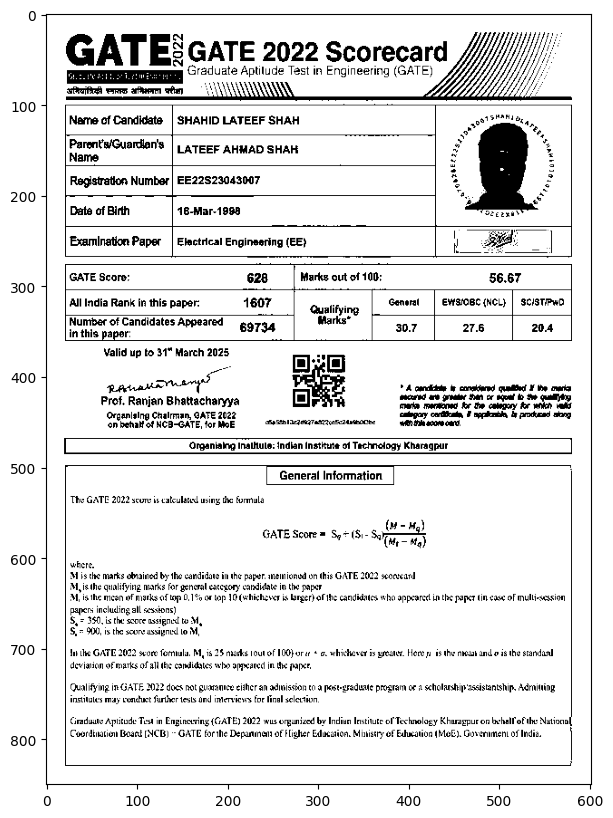

In [577]:
result = bw_scanner(grayi)
plot_gray(result)

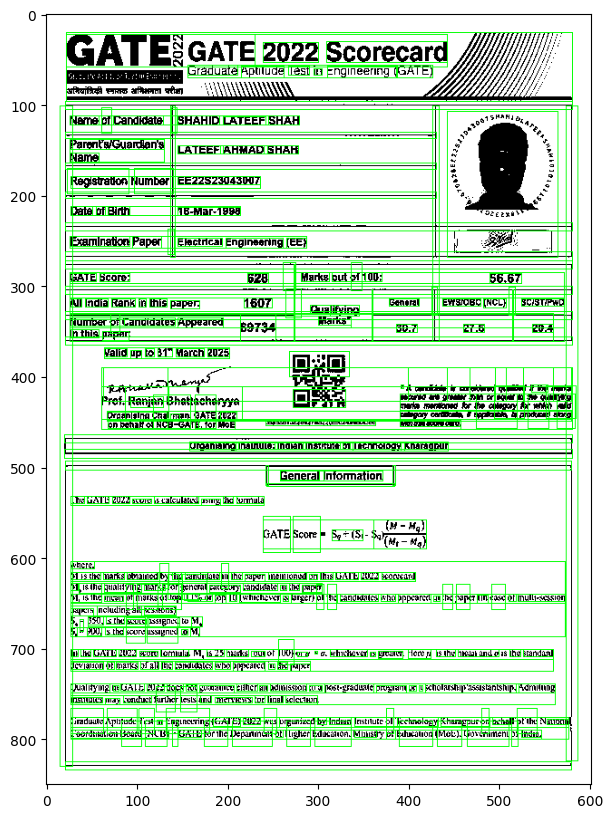

In [578]:
d = pytesseract.image_to_data(result, output_type=Output.DICT)

n_boxes = len(d['level'])
boxes = cv2.cvtColor(result.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
    
plot_rgb(boxes)

In [579]:

extracted_text_grayi = pytesseract.image_to_string(grayi)
# para_grayi = convert_to_paragraph(extracted_text_grayi)
extracted_text_result = pytesseract.image_to_string(result)
# para_result = convert_to_paragraph(extracted_text_result)
combined_text = extracted_text_grayi + "\n" + extracted_text_result
print(combined_text)

GATE GATE 2022 Scorecard

Graduate Aptitude Test in Engineering (GATE)

Name of Candidate | SHAHID LATEEF SHAH

Parent's/Guardian’s | | aTEEF AHMAD SHAH
Name

Registration Number| EE22S23043007

Date of Birth 18-Mar-1998

Examination Paper | Electrical Engineering (EE)

GATE Score: 628 Marks out of 100: 56.67
Al India Rank inthis paper: 1607 Quaitying Seat EWSIOBE NCL) | ScisTRWo
‘Number of Candidates Appeared Marks*
lntropanan 69734 30.7 218 20.4
Valid up to 31% March 2025
icant i “Aci ate 1 at
Prof. Ranjan Bhattacharyya Bria ‘ate noted yo cgay Wh ad
Organising Chairman, GATE 2022 (toga ental, epi i prodod ang
onbehalfofNCBMGATE, for MoE <stacetar \wothiocorcar
‘Organising Institute: indian Institute of Technology Kharagpur
General Information |
‘The GATE 2022 sori cleulated using the formula

‘mas obtained bythe candids in the paper, mentioned on this GATE 2022 seorecard
[M,isthe qualifying marks for general category candidate inthe paper

[Mls the mean of marks of tp 0.1% o top 10 (

In [580]:
extracted_info  =  extract_gate_info(combined_text)
print(extracted_info)

{'Name': 'SHAHID LATEEF SHAH', "Parent's/Guardian's Name": 'Not found', 'Registration Number': 'EE22S23043007', 'Date of Birth': '18 Mar 1998', 'GATE Score': '628', 'Examination Paper': '| Electrical Engineering (EE)', 'All India Rank': '1607', 'Exam Year': '2022'}


In [581]:
def display_results(results):
    table = PrettyTable()
    table.field_names = ["Field", "Value"]
    table.align["Field"] = "l"
    table.align["Value"] = "l"
    
    for key, value in results.items():
        table.add_row([key, value])
    
    print(table)
display_results(extracted_info)

+--------------------------+-------------------------------+
| Field                    | Value                         |
+--------------------------+-------------------------------+
| Name                     | SHAHID LATEEF SHAH            |
| Parent's/Guardian's Name | Not found                     |
| Registration Number      | EE22S23043007                 |
| Date of Birth            | 18 Mar 1998                   |
| GATE Score               | 628                           |
| Examination Paper        | | Electrical Engineering (EE) |
| All India Rank           | 1607                          |
| Exam Year                | 2022                          |
+--------------------------+-------------------------------+


In [582]:
para_grayi = convert_to_paragraph(extracted_text_grayi)
para_result = convert_to_paragraph(extracted_text_result)
new_combined = para_grayi + para_result
print(new_combined)

GATE GATE 2022 Scorecard, Graduate Aptitude Test in Engineering (GATE), Name of Candidate | SHAHID LATEEF SHAH, Parent's/Guardian’s | | aTEEF AHMAD SHAH, Name, Registration Number| EE22S23043007, Date of Birth 18-Mar-1998, Examination Paper | Electrical Engineering (EE), GATE Score: 628 Marks out of 100: 56.67, Al India Rank inthis paper: 1607 Quaitying Seat EWSIOBE NCL) | ScisTRWo, ‘Number of Candidates Appeared Marks*, lntropanan 69734 30.7 218 20.4, Valid up to 31% March 2025, icant i “Aci ate 1 at, Prof. Ranjan Bhattacharyya Bria ‘ate noted yo cgay Wh ad, Organising Chairman, GATE 2022 (toga ental, epi i prodod ang, onbehalfofNCBMGATE, for MoE <stacetar \wothiocorcar, ‘Organising Institute: indian Institute of Technology Kharagpur, General Information |, ‘The GATE 2022 sori cleulated using the formula, ‘mas obtained bythe candids in the paper, mentioned on this GATE 2022 seorecard, [M,isthe qualifying marks for general category candidate inthe paper, [Mls the mean of marks of tp 0.

In [583]:
def extract_parent_name_from_paragraph(text):
    # Pattern to match the parent's/guardian's name
    pattern = r"Parent['’]s/Guardian['’]s\s*[,|:]\s*([A-Z][a-zA-Z\s]+)"
    
    # Search for the match
    match = re.search(pattern, text)
    
    if match:
        return match.group(1).strip()  # Return the matched name, stripped of whitespace
    else:
        return "Parent's/Guardian's name not found"

gharwalo_ka_naam =  extract_parent_name_from_paragraph(new_combined)
print(gharwalo_ka_naam)

Parent's/Guardian's name not found
